In [ ]:
%pip install -r requirements.txt

In [ ]:
import time
import sys
import logging
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
import xgboost as xgb
import lightgbm as lgb

from utils.measurements import measure_resources
from utils.visualization import plot_optuna_attributes, plot_confusion_matrix
from utils.callbacks import ThresholdStopper, EarlyStoppingCallback
from utils.save_util import save_hyper_params_to_yaml, save_params
from utils.check_hardware import check_gpu
from objectives_func.ensembles.xgb import objective_xgb
from objectives_func.ensembles.lgbm import objective_lgbm

In [ ]:
gpu_available = check_gpu()
print(f"GPU available: {gpu_available}")


GPU available: True


# 1. Preprocessing

In [38]:
!gdown 1JIlvi5hf2CkU_AJEVFap8AR3i-FCmjek

Downloading...
From (original): https://drive.google.com/uc?id=1JIlvi5hf2CkU_AJEVFap8AR3i-FCmjek
From (redirected): https://drive.google.com/uc?id=1JIlvi5hf2CkU_AJEVFap8AR3i-FCmjek&confirm=t&uuid=ff3448e3-45d4-4900-9d52-05f937c9bce0
To: /content/[10-02] cicids2018_preprocessed.parquet
100% 790M/790M [00:09<00:00, 86.6MB/s]


In [ ]:
# Set the path to the file you'd like to load
file_path = "cicids2018_preprocessed.parquet"
df = pd.read_parquet(file_path)

In [ ]:
df.Label.value_counts(dropna=False)

,count
Label,
Benign,4263038
DoS attacks-Hulk,439126
DDOS attack-HOIC,360833
Bot,285763
FTP-BruteForce,193354
SSH-Bruteforce,187589
Infilteration,152861
DoS attacks-SlowHTTPTest,139890
DoS attacks-GoldenEye,39924


In [ ]:
df = df[df.Label != "Attack"]

In [ ]:
attack_mapping = {
    "Benign": "Normal",
    # DoS
    "DoS attacks-Hulk": "DoS",
    "DoS attacks-SlowHTTPTest": "DoS",
    "DoS attacks-GoldenEye": "DoS",
    "DoS attacks-Slowloris": "DoS",
    # DDoS
    "DDOS attack-HOIC": "DDoS",
    "DDOS attack-LOIC-UDP": "DDoS",
    # Botnet
    "Bot": "Botnet",
    # Brute Force
    "FTP-BruteForce": "BruteForce",
    "SSH-Bruteforce": "BruteForce",
    # Infiltration
    "Infilteration": "Infilteration",
}

In [ ]:
df.Label = df.Label.map(attack_mapping)

## Split train/cv/test sets

In [ ]:
X = df.drop(columns=["Label"])
y = df["Label"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Check class distribution in train/test set

/tmp/ipython-input-575620800.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, ax=ax, palette="Set2")
/tmp/ipython-input-575620800.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, ax=ax, palette="Set2")
/tmp/ipython-input-575620800.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, ax=ax, palette="Set2")


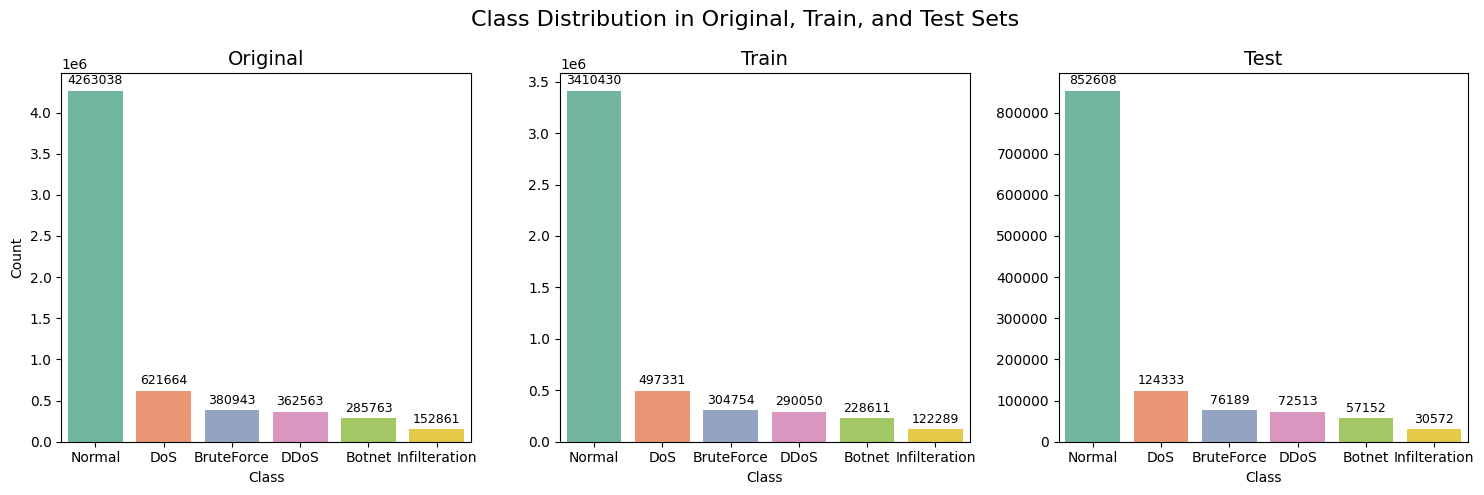

In [ ]:
counts_list = [
    ("Original", y.value_counts()),
    ("Train", y_train.value_counts()),
    ("Test", y_test.value_counts()),
]

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (title, counts) in zip(axes, counts_list):
    sns.barplot(x=counts.index, y=counts.values, ax=ax, palette="Set2")
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Class")
    ax.set_ylabel("Count" if title == "Original" else "")  # only left plot shows ylabel
    for i, v in enumerate(counts.values):
        ax.text(
            i,
            v + 0.01 * max(counts.values),
            str(v),
            ha="center",
            va="bottom",
            fontsize=9,
        )

plt.suptitle("Class Distribution in Original, Train, and Test Sets", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
y_train = (y_train != "Normal").astype(int)
y_test = (y_test != "Normal").astype(int)

**Subset with only anomalous traffic** - uses to evaluate missing ratio

In [ ]:
df_full_anol = df[df.Label != "Normal"]
X_full_anol = df_full_anol.drop(columns=["Label"])
y_full_anol = (df_full_anol["Label"] != "Normal").astype(int)

**Subset with only normal traffic** - uses to evaluate false alarm rate

In [ ]:
df_no_anol = df[df.Label == "Normal"]
X_no_anol = df_no_anol.drop(columns=["Label"])
y_no_anol = (df_no_anol["Label"] != "Normal").astype(int)

# Benchmarking
## Ensemble models

### Define maximum trials and termination conditions (for early stopping)

In [ ]:
DEAFAULT_N_TRIALS = 30

In [ ]:
early_stop = EarlyStoppingCallback(patience=5, threshold=0.05, direction="maximize")
threshold_stop = ThresholdStopper(threshold=0.99)

## XGBoost Classfier
### Fine-tuning

In [ ]:
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
xgb_study = optuna.create_study(direction="maximize")
xgb_study.optimize(
    lambda trial: objective_xgb(
        trial, xgb.XGBClassifier, X_train, y_train, X_test, y_test
    ),
    n_trials=DEAFAULT_N_TRIALS,
    callbacks=[early_stop, threshold_stop],
)

[I 2025-10-02 09:16:51,606] A new study created in memory with name: no-name-3f023ea8-a122-4e59-8c22-24fb865a7b89


A new study created in memory with name: no-name-3f023ea8-a122-4e59-8c22-24fb865a7b89
A new study created in memory with name: no-name-3f023ea8-a122-4e59-8c22-24fb865a7b89
A new study created in memory with name: no-name-3f023ea8-a122-4e59-8c22-24fb865a7b89


[I 2025-10-02 09:18:26,914] Trial 0 finished with value: 0.9035456263620503 and parameters: {'booster': 'gbtree', 'max_depth': 3, 'learning_rate': 0.002888683119131458, 'n_estimators': 588, 'min_child_weight': 10, 'gamma': 8.723815975333004, 'subsample': 0.9034799808802074, 'sampling_method': 'gradient_based', 'colsample_bytree': 0.8422046713602732, 'colsample_bylevel': 0.6435524533897989, 'colsample_bynode': 0.5404792456113388, 'alpha': 5.148324526318395e-08, 'lambda': 0.0021079836505704767, 'scale_pos_weight': 8.887618068219075, 'grow_policy': 'lossguide', 'max_leaves': 224, 'max_bin': 470}. Best is trial 0 with value: 0.9035456263620503.


Trial 0 finished with value: 0.9035456263620503 and parameters: {'booster': 'gbtree', 'max_depth': 3, 'learning_rate': 0.002888683119131458, 'n_estimators': 588, 'min_child_weight': 10, 'gamma': 8.723815975333004, 'subsample': 0.9034799808802074, 'sampling_method': 'gradient_based', 'colsample_bytree': 0.8422046713602732, 'colsample_bylevel': 0.6435524533897989, 'colsample_bynode': 0.5404792456113388, 'alpha': 5.148324526318395e-08, 'lambda': 0.0021079836505704767, 'scale_pos_weight': 8.887618068219075, 'grow_policy': 'lossguide', 'max_leaves': 224, 'max_bin': 470}. Best is trial 0 with value: 0.9035456263620503.
Trial 0 finished with value: 0.9035456263620503 and parameters: {'booster': 'gbtree', 'max_depth': 3, 'learning_rate': 0.002888683119131458, 'n_estimators': 588, 'min_child_weight': 10, 'gamma': 8.723815975333004, 'subsample': 0.9034799808802074, 'sampling_method': 'gradient_based', 'colsample_bytree': 0.8422046713602732, 'colsample_bylevel': 0.6435524533897989, 'colsample_byn

[I 2025-10-02 09:20:50,259] Trial 1 finished with value: 0.9945990526588222 and parameters: {'booster': 'gbtree', 'max_depth': 6, 'learning_rate': 0.021855889849578664, 'n_estimators': 830, 'min_child_weight': 2, 'gamma': 1.3941960242952833, 'subsample': 0.8785739787237201, 'sampling_method': 'uniform', 'colsample_bytree': 0.8122103213478572, 'colsample_bylevel': 0.6211201986204787, 'colsample_bynode': 0.6875310438553031, 'alpha': 0.00039116012432011273, 'lambda': 6.318135372824816e-06, 'scale_pos_weight': 4.306729237206141, 'grow_policy': 'depthwise', 'max_leaves': 60, 'max_bin': 384}. Best is trial 1 with value: 0.9945990526588222.


Trial 1 finished with value: 0.9945990526588222 and parameters: {'booster': 'gbtree', 'max_depth': 6, 'learning_rate': 0.021855889849578664, 'n_estimators': 830, 'min_child_weight': 2, 'gamma': 1.3941960242952833, 'subsample': 0.8785739787237201, 'sampling_method': 'uniform', 'colsample_bytree': 0.8122103213478572, 'colsample_bylevel': 0.6211201986204787, 'colsample_bynode': 0.6875310438553031, 'alpha': 0.00039116012432011273, 'lambda': 6.318135372824816e-06, 'scale_pos_weight': 4.306729237206141, 'grow_policy': 'depthwise', 'max_leaves': 60, 'max_bin': 384}. Best is trial 1 with value: 0.9945990526588222.
Trial 1 finished with value: 0.9945990526588222 and parameters: {'booster': 'gbtree', 'max_depth': 6, 'learning_rate': 0.021855889849578664, 'n_estimators': 830, 'min_child_weight': 2, 'gamma': 1.3941960242952833, 'subsample': 0.8785739787237201, 'sampling_method': 'uniform', 'colsample_bytree': 0.8122103213478572, 'colsample_bylevel': 0.6211201986204787, 'colsample_bynode': 0.687531

**Best params after `n_rounds=5`** (with early stopping)

In [ ]:
from datetime import datetime

save_hyper_params_to_yaml(
    xgb_study.best_params, f"[{datetime.date()}]xgb_best_params.yaml"
)

{'booster': 'gbtree',
 'max_depth': 6,
 'learning_rate': 0.021855889849578664,
 'n_estimators': 830,
 'min_child_weight': 2,
 'gamma': 1.3941960242952833,
 'subsample': 0.8785739787237201,
 'sampling_method': 'uniform',
 'colsample_bytree': 0.8122103213478572,
 'colsample_bylevel': 0.6211201986204787,
 'colsample_bynode': 0.6875310438553031,
 'alpha': 0.00039116012432011273,
 'lambda': 6.318135372824816e-06,
 'scale_pos_weight': 4.306729237206141,
 'grow_policy': 'depthwise',
 'max_leaves': 60,
 'max_bin': 384}

In [ ]:
xgb_study.best_trial

FrozenTrial(number=1, state=1, values=[0.9945990526588222], datetime_start=datetime.datetime(2025, 10, 2, 9, 18, 26, 918196), datetime_complete=datetime.datetime(2025, 10, 2, 9, 20, 50, 258868), params={'booster': 'gbtree', 'max_depth': 6, 'learning_rate': 0.021855889849578664, 'n_estimators': 830, 'min_child_weight': 2, 'gamma': 1.3941960242952833, 'subsample': 0.8785739787237201, 'sampling_method': 'uniform', 'colsample_bytree': 0.8122103213478572, 'colsample_bylevel': 0.6211201986204787, 'colsample_bynode': 0.6875310438553031, 'alpha': 0.00039116012432011273, 'lambda': 6.318135372824816e-06, 'scale_pos_weight': 4.306729237206141, 'grow_policy': 'depthwise', 'max_leaves': 60, 'max_bin': 384}, user_attrs={'train_time_sec': 25.597071409225464, 'test_time_sec': 1.0705420970916748, 'cpu_usage_percent_train': 339.5, 'memory_usage_mb_train': 35945.84375, 'gpu_util_percent_train': 42, 'gpu_memory_used_mb_train': 1639.125, 'cpu_usage_percent_test': 524.8, 'memory_usage_mb_test': 35225.648437

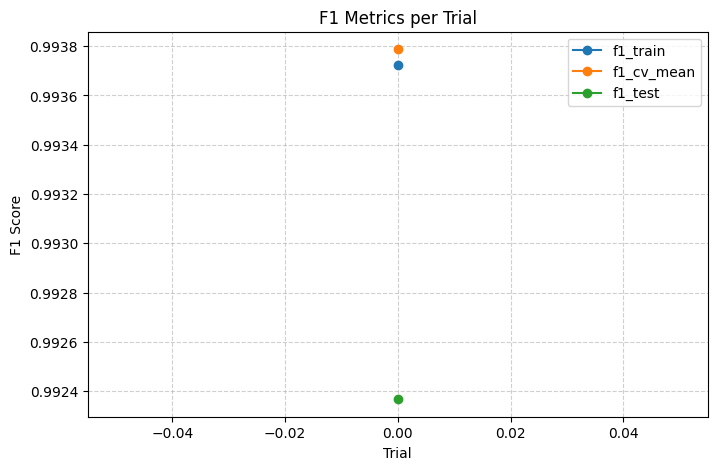

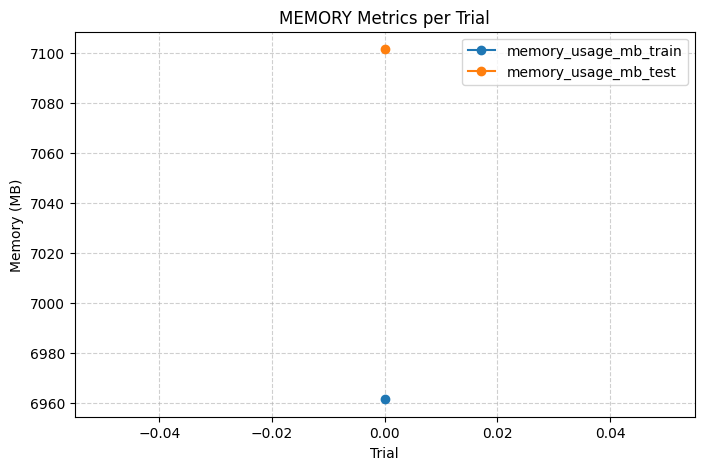

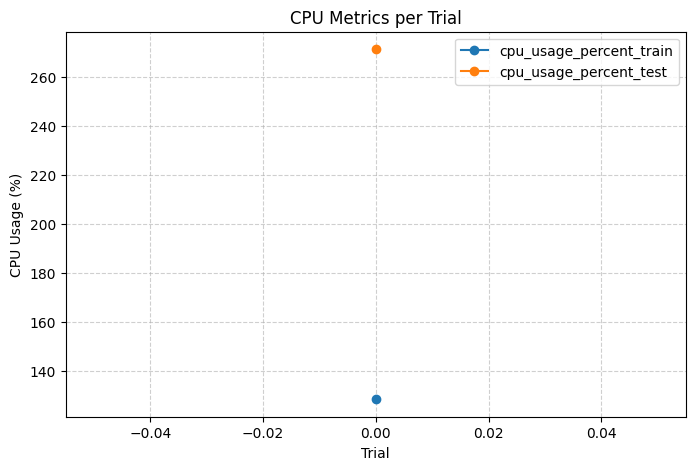

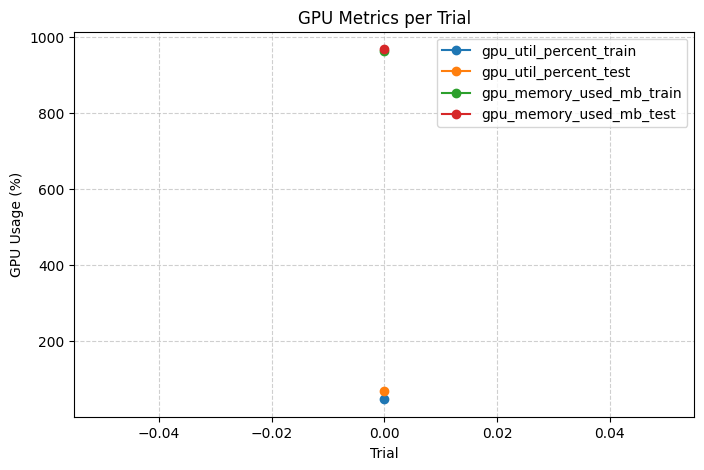

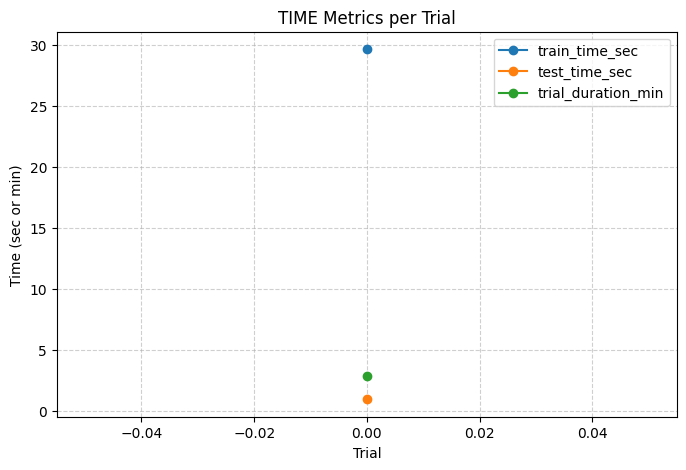

In [ ]:
plot_optuna_attributes(xgb_study)

**Best parameters for `XGBClassifier`**
```python
{
    'booster': 'gbtree',
    'max_depth': 6,
    'learning_rate': 0.021855889849578664,
    'n_estimators': 830,
    'min_child_weight': 2,
    'gamma': 1.3941960242952833,
    'subsample': 0.8785739787237201,
    'sampling_method': 'uniform',
    'colsample_bytree': 0.8122103213478572,
    'colsample_bylevel': 0.6211201986204787,
    'colsample_bynode': 0.6875310438553031,
    'alpha': 0.00039116012432011273,
    'lambda': 6.318135372824816e-06,
    'scale_pos_weight': 4.306729237206141,
    'grow_policy': 'depthwise',
    'max_leaves': 60,
    'max_bin': 384
}
```

In [ ]:
xgb_clf_best_params = {
    "objective": "binary:logistic",
    "device": "cuda",
    "verbosity": 1,
    "eval_metric": "logloss",
    "booster": "gbtree",
    "max_depth": 6,
    "learning_rate": 0.021855889849578664,
    "n_estimators": 830,
    "min_child_weight": 2,
    "gamma": 1.3941960242952833,
    "subsample": 0.8785739787237201,
    "sampling_method": "uniform",
    "colsample_bytree": 0.8122103213478572,
    "colsample_bylevel": 0.6211201986204787,
    "colsample_bynode": 0.6875310438553031,
    "alpha": 0.00039116012432011273,
    "lambda": 6.318135372824816e-06,
    "scale_pos_weight": 4.306729237206141,
    "grow_policy": "depthwise",
    "max_leaves": 60,
    "max_bin": 384,
}

### Retrain with best parameters

In [ ]:
best_xgbc = xgb.XGBClassifier(**xgb_clf_best_params)
results_train_xgb = measure_resources(best_xgbc.fit, X_train, y_train)

In [ ]:
for key, value in results_train_xgb.items():
    if key != "result":
        print(f"{key} at train time: {value}")

elapsed_time_sec at train time: 25.452024221420288
cpu_usage at train time: 343.3
python_peak_memory_mb at train time: 35952.71484375
gpu_util_percent at train time: 80
gpu_memory_used_mb at train time: 1639.125


### **CV and test with original distribution test-set**

In [ ]:
cross_vl = cross_val_score(best_xgbc, X_train, y_train, cv=5)

In [ ]:
print("Cross-validation score of XBGoost:", np.mean(cross_vl))

Cross-validation score of XBGoost: 0.9945158768014192


In [ ]:
start = time.time()
results_test_xgb = measure_resources(best_xgbc.predict, X_test)
y_pred_xgb = results_test_xgb["result"]
end = time.time()
print(f"Time to detect XGBoost: {(end - start) / len(y_test)}")

Time to detect XGBoost: 8.332083534642821e-07


In [ ]:
for key, value in results_test_xgb.items():
    if key != "result":
        print(f"{key} at test: {value}")

elapsed_time_sec at test: 0.955662727355957
cpu_usage at test: 480.4
python_peak_memory_mb at test: 35139.69140625
gpu_util_percent at test: 56
gpu_memory_used_mb at test: 1625.125


In [ ]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    852608
           1       0.98      1.00      0.99    360759

    accuracy                           0.99   1213367
   macro avg       0.99      1.00      0.99   1213367
weighted avg       0.99      0.99      0.99   1213367



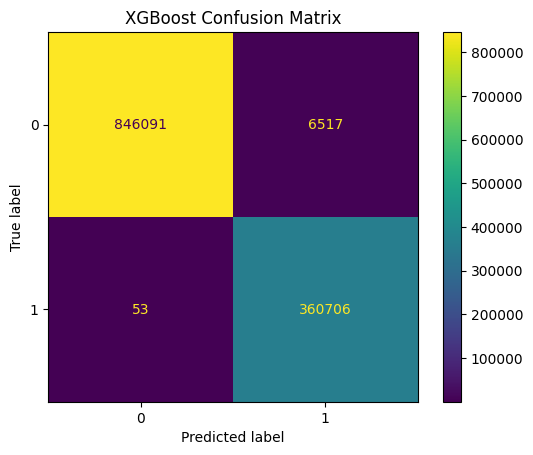

In [ ]:
xgb_confusion = confusion_matrix(y_test, y_pred_xgb)
xgb_cm_display = ConfusionMatrixDisplay(
    confusion_matrix=xgb_confusion, display_labels=[0, 1]
)

xgb_cm_display.plot()
plt.title("XGBoost Confusion Matrix")
plt.show()

In [ ]:
print(f"Time to detect XGBoost: {(results_test_xgb['elapsed_time_sec'] / len(y_test))}")

Time to detect XGBoost: 7.876122618762147e-07


### **Test with full anomalous population**

In [ ]:
start = time.time()
results_test_xgb_full_anol = measure_resources(best_xgbc.predict, X_full_anol)
end = time.time()
print(f"Time to detect XGBoost: {(end - start) / len(y_test)}")

Time to detect XGBoost: 1.2454042995350864e-06


In [ ]:
y_pred_xgb_full_anol = results_test_xgb_full_anol["result"]
print(classification_report(y_full_anol, y_pred_xgb_full_anol, zero_division=0.0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      1.00      1.00   1803794

    accuracy                           1.00   1803794
   macro avg       0.50      0.50      0.50   1803794
weighted avg       1.00      1.00      1.00   1803794



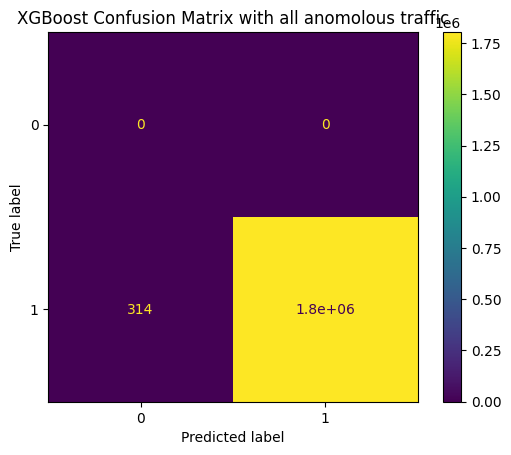

In [ ]:
xgb_confusion_full_anol = confusion_matrix(y_full_anol, y_pred_xgb_full_anol)
xgb_cm_display_full_anol = ConfusionMatrixDisplay(
    confusion_matrix=xgb_confusion_full_anol, display_labels=[0, 1]
)

xgb_cm_display_full_anol.plot()
plt.title("XGBoost Confusion Matrix with all anomolous traffic")
plt.show()


In [ ]:
xgb_confusion_full_anol

### **Test with no anomalous population**

In [ ]:
y_no_anol.value_counts()

,count
Label,
0,4263038


In [ ]:
start = time.time()
results_test_xgb_no_anol = measure_resources(best_xgbc.predict, X_no_anol)
end = time.time()
print(f"Time to detect XGBoost: {(end - start) / len(y_no_anol)}")

Time to detect XGBoost: 8.250000110830151e-07


In [ ]:
y_pred_xgb_no_anol = results_test_xgb_no_anol["result"]
print(classification_report(y_full_anol, y_pred_xgb_full_anol, zero_division=0.0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      1.00      1.00   1803794

    accuracy                           1.00   1803794
   macro avg       0.50      0.50      0.50   1803794
weighted avg       1.00      1.00      1.00   1803794



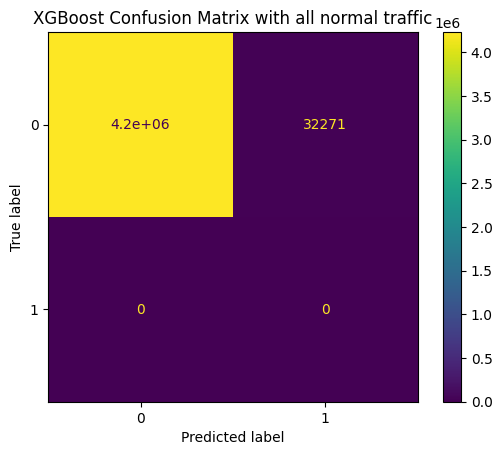

In [ ]:
xgb_confusion_no_anol = confusion_matrix(y_no_anol, y_pred_xgb_no_anol)
xgb_cm_display_no_anol = ConfusionMatrixDisplay(
    confusion_matrix=xgb_confusion_no_anol, display_labels=[0, 1]
)

xgb_cm_display_no_anol.plot()
plt.title("XGBoost Confusion Matrix with all normal traffic")
plt.show()

### **Save models**

In [ ]:
import pickle

file_name = "xgb_cicids2018.pkl"
# save
pickle.dump(best_xgbc, open(file_name, "wb"))


## LightGBM

### Hyperparameters tuning

In [ ]:
lgbm_study = optuna.create_study(direction="maximize")
lgbm_study.optimize(
    lambda trial: objective_lgbm(
        trial, lgb.LGBMClassifier, X_train, y_train, X_test, y_test
    ),
    n_trials=DEAFAULT_N_TRIALS,
    callbacks=[early_stop, threshold_stop],
)

[I 2025-10-02 13:11:43,550] A new study created in memory with name: no-name-d199a910-60dc-4cad-9c3a-272342aed907


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.8154758771069812 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.7989410305665877, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7989410305665877
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l1 is set=0.006969116080052618, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006969116080052618
[LightGBM] [Warning] lambda_l2 is set=1.1775033880853936e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1775033880853936e-05
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fract

[I 2025-10-02 13:29:39,894] Trial 0 finished with value: 0.9962988209127572 and parameters: {'boosting_type': 'goss', 'num_leaves': 366, 'max_depth': 12, 'learning_rate': 0.26601018868269477, 'n_estimators': 563, 'subsample': 0.8154758771069812, 'tree_learner': 'data', 'min_child_samples': 58, 'min_child_weight': 27.59812564116969, 'lambda_l1': 0.006969116080052618, 'lambda_l2': 1.1775033880853936e-05, 'feature_fraction': 0.7989410305665877, 'extra_trees': False, 'top_rate': 0.3341344468911299, 'other_rate': 0.16405797283716905, 'pos_bagging_fraction': 0.6563445174193618, 'neg_bagging_fraction': 0.44157259224568646}. Best is trial 0 with value: 0.9962988209127572.


Stopping study! Best value 0.9962988209127572 <= threshold 0.99


In [ ]:
lgbm_study.trials

In [ ]:
lgbm_study.best_params

In [ ]:
lgbm_best_params = {
    "objective": "binary",
    "device": "gpu",
    "verbosity": 0,
    "eval_metric": "logloss",
    "boosting_type": "goss",
    "num_leaves": 54,
    "max_depth": 6,
    "learning_rate": 0.03168606336446395,
    "n_estimators": 376,
    "subsample": 0.9732773502317136,
    "tree_learner": "serial",
    "colsample_bytree": 0.7779246297003738,
    "min_child_samples": 46,
    "min_child_weight": 0.0049656088026181445,
    "lambda_l1": 3.485203479609063e-07,
    "lambda_l2": 0.0012932480056061738,
    "extra_trees": False,
    "feature_fraction": 0.8969128906566174,
}

```python
{
    "objective": "binary",
    "device": "gpu",
    "verbosity": 0,
    "eval_metric": "logloss",
    'boosting_type': 'goss',
    'num_leaves': 54,
    'max_depth': 6,
    'learning_rate': 0.03168606336446395,
    'n_estimators': 376,
    'subsample': 0.9732773502317136,
    'tree_learner': 'serial',
    'colsample_bytree': 0.7779246297003738,
    'min_child_samples': 46,
    'min_child_weight': 0.0049656088026181445,
    'lambda_l1': 3.485203479609063e-07,
    'lambda_l2': 0.0012932480056061738,
    'extra_trees': False,
    'feature_fraction': 0.8969128906566174
}
```

### Retrain `LGBMClassifier` with best parameters

In [ ]:
best_lgbm = lgb.LGBMClassifier(**lgbm_best_params)
results_train_lgbm = measure_resources(best_lgbm.fit, X_train, y_train)

In [ ]:
for key, value in results_train_lgbm.items():
    if key != "result":
        print(f"{key}: {value}")

### **CV and test with original distribution test-set**

In [ ]:
cross_val_lgbm = cross_val_score(best_lgbm, X_train, y_train, cv=5)

In [ ]:
print("Cross-validation score of LightGBM:", np.mean(cross_val_lgbm))

In [ ]:
start = time.time()
results_test_lgbm = measure_resources(best_lgbm.predict, X_test)
y_pred = results_test_lgbm["result"]
end = time.time()

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.8969128906566174, colsample_bytree=0.7779246297003738 will be ignored. Current value: feature_fraction=0.8969128906566174
[LightGBM] [Warning] lambda_l2 is set=0.0012932480056061738, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012932480056061738
[LightGBM] [Warning] lambda_l1 is set=3.485203479609063e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.485203479609063e-07
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


In [ ]:
print(f"Time to detect LightGBM: {(end - start) / len(y_test)}")

Time to detect LightGBM: 5.047023568280235e-06


In [ ]:
for key, value in results_test_lgbm.items():
    if key != "result":
        print(f"{key}: {value}")

elapsed_time_sec: 3.7715859413146973
cpu_usage: 562.5
python_peak_memory_mb: 6849.328125
gpu_util_percent: 0
gpu_memory_used_mb: 967.125


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    628518
           1       0.99      1.00      1.00    127708

    accuracy                           1.00    756226
   macro avg       1.00      1.00      1.00    756226
weighted avg       1.00      1.00      1.00    756226



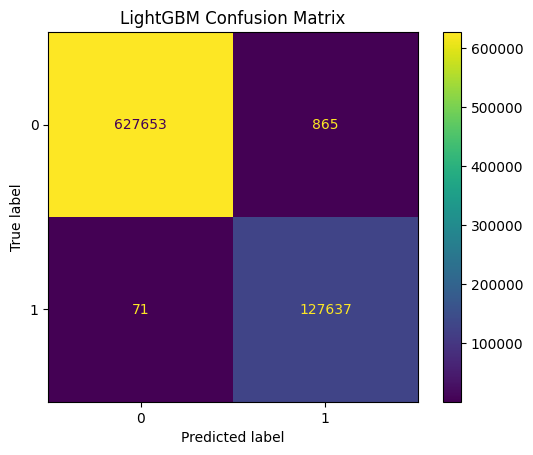

In [ ]:
lgbm_confusion = confusion_matrix(y_test, y_pred)
lgbm_cm_display = ConfusionMatrixDisplay(
    confusion_matrix=lgbm_confusion, display_labels=[0, 1]
)

lgbm_cm_display.plot()
plt.title("LightGBM Confusion Matrix")
plt.show()

### **Test with full anomalous population**

In [ ]:
start = time.time()
results_test_lgbm_full_anol = measure_resources(best_lgbm.predict, X_full_anol)
end = time.time()
print(f"Time to detect LGBM: {(end - start) / len(y_test)}")

In [ ]:
y_pred_LGBM_full_anol = results_test_LGBM_full_anol["result"]
print(classification_report(y_full_anol, y_pred_LGBM_full_anol, zero_division=0.0))

### Save model